In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, RobertaConfig
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load dataset
df = pd.read_csv("/content/fake reviews dataset (5).csv")

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Preprocessing
lemmatizer = WordNetLemmatizer()
#stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word.lower() for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    #tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    return ' '.join(tokens)

df['cleaned_text'] = df['text_'].apply(preprocess_text)

In [ ]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['cleaned_text']).toarray()
X_normalized = normalize(X)

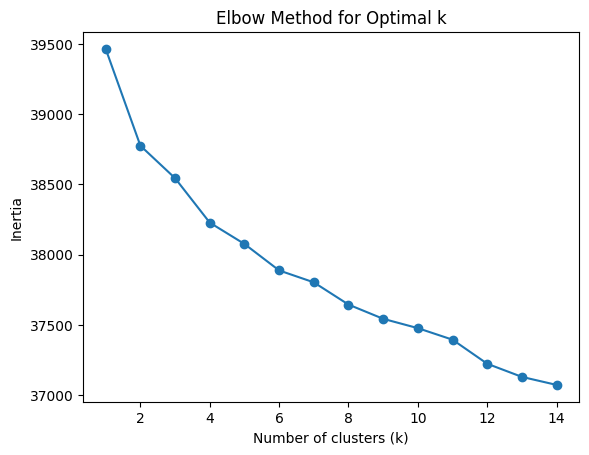

In [ ]:
# K-Means Clustering
inertia = []
k_range = range(1, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalized)
    inertia.append(kmeans.inertia_)

# Elbow method visualization
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [ ]:
# Apply optimal K-Means
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_final.fit(X_normalized)
df['cluster'] = kmeans_final.labels_
silhouette_avg_kmeans = silhouette_score(X_normalized, df['cluster'])
print(f"Silhouette Score for K-Means: {silhouette_avg_kmeans}")

Silhouette Score for K-Means: 0.012088915486326998


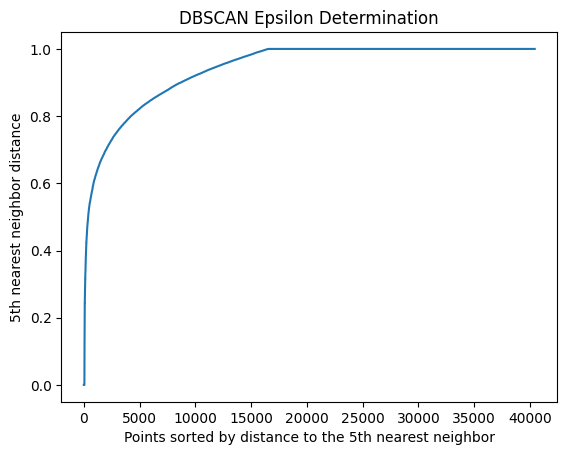

In [ ]:
# DBSCAN Clustering
nearest_neighbors = NearestNeighbors(n_neighbors=3).fit(X_normalized)
distances, indices = nearest_neighbors.kneighbors(X_normalized)
distances = np.sort(distances[:, -1])

# Plot distances to determine epsilon
plt.plot(distances)
plt.xlabel("Points sorted by distance to the 5th nearest neighbor")
plt.ylabel("5th nearest neighbor distance")
plt.title("DBSCAN Epsilon Determination")
plt.show()

In [ ]:
epsilon = 0.6  # Based on the graph
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_normalized)
df['dbscan_cluster'] = dbscan_labels

# Filter out noise (-1 cluster)
filtered_df = df[df['dbscan_cluster'] != -1]
filtered_X = X[dbscan_labels != -1]
filtered_labels = dbscan_labels[dbscan_labels != -1]


In [ ]:
# Silhouette Score for DBSCAN
if len(set(filtered_labels)) > 1:
    silhouette_avg_dbscan = silhouette_score(filtered_X, filtered_labels)
    print(f"Silhouette Score for DBSCAN: {silhouette_avg_dbscan}")
else:
    print("Silhouette Score cannot be computed due to insufficient clusters.")


Silhouette Score for DBSCAN: 0.2988990137210101


In [ ]:
# LDA Topic Modeling
lda_model = LatentDirichletAllocation(n_components=optimal_k, random_state=42)
lda_topics = lda_model.fit_transform(X)
# Print topics
print("Topics from LDA:")
for idx, topic in enumerate(lda_model.components_):
    print(f"Topic {idx + 1}: ", [tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topics from LDA:
Topic 1:  ['thi', 'food', 'problem', 'love', 'product', 'great', 'cat', 'work', 'use', 'dog']
Topic 2:  ['good', 'qualiti', 'bought', 'littl', 'nice', 'size', 'use', 'fit', 'great', 'love']
Topic 3:  ['thi', 'author', 'good', 'seri', 'enjoy', 'love', 'charact', 'stori', 'read', 'book']
Topic 4:  ['love', 'time', 'like', 'great', 'stori', 'film', 'act', 'good', 'watch', 'movi']


In [ ]:
# Map topics back to reviews
df['topic'] = lda_topics.argmax(axis=1)

In [ ]:
# Classification: Logistic Regression and SVM
X_class = tfidf.transform(df['cleaned_text']).toarray()
y_class = df['label']
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

          CG       0.86      0.83      0.84      6066
          OR       0.84      0.86      0.85      6064

    accuracy                           0.85     12130
   macro avg       0.85      0.85      0.85     12130
weighted avg       0.85      0.85      0.85     12130



In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Classification Report:
               precision    recall  f1-score   support

          CG       0.88      0.85      0.87      6066
          OR       0.85      0.89      0.87      6064

    accuracy                           0.87     12130
   macro avg       0.87      0.87      0.87     12130
weighted avg       0.87      0.87      0.87     12130

